# Introduction

This portfolio / blog details n Dta Analytics and Science for Python. We will be discussing our project to give you an overview on how to use Pyhton for Data Science.
Our project goes by the name of "Sentimental Analysis on SAamaxon Fine Food Dataset".

We will be primarily focussing on the following topics:
    -Data Cleaning and Data Pre-processing
    -Applying regression models on a dataset to prdeict the sentiment
    -Using deep learning techniques for text generation


About our dataset:
    
This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.
You can find the dataset at: https://www.kaggle.com/snap/amazon-fine-food-reviews
        
Data includes:
    - Reviews from Oct 1999 - Oct 2012
    - 568,454 reviews
    - 256,059 users
    - 74,258 products
    - 260 users with > 50 reviews

What do we plan to do?

We plan on performing sentimental analysis. Sentiment analysis is the measurement of positive and negative language. It is a way to evaluate written or spoken language to determine if the expression is favorable, unfavorable, or neutral, and to what degree. Today’s algorithm-based sentiment analysis tools can handle huge volumes of customer feedback consistently and accurately. Paired with text analytics, sentiment analysis reveals the customer’s opinion about topics ranging from your products and services to your location, your advertisements, or even your competitors.
With our dataset, we aim to  build a prediction model where we will be able to predict if a review is positive or negative. In addition to that, we plan on generating auto-summaries on the basis of the reviews given by the user.

The approach which we are going to use is , we will build a Term-doc incidence matrix using term frequency and inverse document frequency ponderation. When the data is ready, we will load it into predicitve algorithms, mainly naïve Bayesian and regression.

We will be mainly following the Bag of Words model.
A bag-of-words model, or BoW for short, is a way of extracting features from text for use in modeling, such as with machine learning algorithms.

The approach is very simple and flexible, and can be used in a myriad of ways for extracting features from documents.

A bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:

    A vocabulary of known words.
    A measure of the presence of known words.

It is called a “bag” of words, because any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not where in the document.

The intuition is that documents are similar if they have similar content. Further, that from the content alone we can learn something about the meaning of the document.
    
The bag-of-words can be as simple or complex as you like. The complexity comes both in deciding how to design the vocabulary of known words (or tokens) and how to score the presence of known words.

# Loading the Data and importing the necessary libraries:

The libraries that we will be needing are: 
1. Numpy : NumPy is a library for the Python programming language, adding support for large, multi-dimensional   arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.

2. Pandas :  Pandas is a software library written for the Python programming language for data manipulation and analysis. In particular, it offers data structures and operations for manipulating numerical tables and time series.

3. Matplotlib : Matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy.

4. NLTK : NLTK is a suite of libraries and programs for symbolic and statistical natural language processing (NLP) for English written in the Python programming language. 

5. Scikit-learn : Scikit-learn is a machine learning library for the Python programming language. It features various classification, regression and clustering algorithms including support vector machines, random forests, gradient boosting, k-means and DBSCAN.

6. Wordcloud : Wordcloud is a library for visual representation of text data, typically used to depict keyword metadata (tags) on websites, or to visualize free form text.


We shall be loading all the above libraries and several of theri features which we will be using in this program.

In order to load the data, we will be using the dataset which is in the format of SQLITE. We will use the sqlite3 library to import the file.

In [2]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

The dataframe which will store all the data from the sqlite file will be called: "amazon".
Using the SQL statement to check if the data has been correctly imported.

In [27]:
amazon = sqlite3.connect('E:/database.sqlite')

pd.read_sql_query("SELECT * FROM Reviews LIMIT 3", amazon)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In this dataset, for sentimental analysis, we only need Score, Summary, HelpfulnessNumerator and, HelpfulnessDenominator. So, we create a new dataframe called "useful_amazon" with only the columns listed above. Also, since we will be classifying data according to the ratings, we will be removing the rating of 3, since 3 in neutral and neither falls in positive or negative.

In [28]:
useful_amazon = pd.read_sql_query("""
SELECT 
  Score, 
  Summary, 
  HelpfulnessNumerator as VotesHelpful, 
  HelpfulnessDenominator as VotesTotal
FROM Reviews 
WHERE Score != 3""", amazon)

In [29]:
useful_amazon .head(5)

,Score,Summary,VotesHelpful,VotesTotal
0,5,Good Quality Dog Food,1,1
1,1,Not as Advertised,0,0
2,4,"""Delight"" says it all",1,1
3,2,Cough Medicine,3,3
4,5,Great taffy,0,0


Here, we will be doing feature classification which is basically choosing informative, discriminating and independent features for effective algorithms in pattern recognition, classification and regression. 

We simply classify the scores as positive and negative. The scores of 1 & 2 become negative and 4 & 5 become positive and give it a separate column as "Sentiment". Also, we create a seperate column of "Usefulness" which basically classifies Voteshelpful/VotesTotal as useful when it is about 0.8, and useless if it is below 0.8.


In [30]:
useful_amazon ["Sentiment"] = useful_amazon ["Score"].apply(lambda score: "positive" if score > 3 else "negative")
useful_amazon ["Usefulness"] = (useful_amazon ["VotesHelpful"]/useful_amazon ["VotesTotal"]).apply(lambda n: "useful" if n > 0.8 else "useless")

useful_amazon .head(5)

,Score,Summary,VotesHelpful,VotesTotal,Sentiment,Usefulness
0,5,Good Quality Dog Food,1,1,positive,useful
1,1,Not as Advertised,0,0,negative,useless
2,4,"""Delight"" says it all",1,1,positive,useful
3,2,Cough Medicine,3,3,negative,useful
4,5,Great taffy,0,0,positive,useless


Performing some data exploration

In [31]:
useful_amazon [useful_amazon .Score == 5].head(10)

,Score,Summary,VotesHelpful,VotesTotal,Sentiment,Usefulness
0,5,Good Quality Dog Food,1,1,positive,useful
4,5,Great taffy,0,0,positive,useless
6,5,Great! Just as good as the expensive brands!,0,0,positive,useless
7,5,"Wonderful, tasty taffy",0,0,positive,useless
8,5,Yay Barley,1,1,positive,useful
9,5,Healthy Dog Food,0,0,positive,useless
10,5,The Best Hot Sauce in the World,1,1,positive,useful
11,5,"My cats LOVE this ""diet"" food better than thei...",4,4,positive,useful
14,5,Strawberry Twizzlers - Yummy,4,5,positive,useless
15,5,"Lots of twizzlers, just what you expect.",4,5,positive,useless


In [9]:
useful_amazon [messages.Score == 1].head(10)

,Score,Summary,VotesHelpful,VotesTotal,Sentiment,Usefulness
1,1,Not as Advertised,0,0,negative,useless
12,1,My Cats Are Not Fans of the New Food,1,1,negative,useful
26,1,Nasty No flavor,0,1,negative,useless
47,1,Don't like it,0,7,negative,useless
57,1,stale product.,2,2,negative,useful
67,1,Warning! WARNING! -ALCOHOL SUGARS!,0,1,negative,useless
69,1,No Tea Flavor,0,0,negative,useless
90,1,Bad,0,1,negative,useless
140,1,Rip off Price,1,1,negative,useful
150,1,Tasteless but low calorie,0,4,negative,useless


# Processing and Cleaning data

Now that we are done importing the necessary libraries, loading the data and extracting the useful features we shall proceed with data cleaning and pre processing.
A vital component of data science involves acquiring raw data and getting it into a form ready for analysis. In fact, it is commonly said that data scientists spend 80% of their time cleaning and manipulating data, and only 20% of their time actually analyzing it. With numerical data, we primarily focus on sorting out outliers and null values.

However, data primarily consists of text data, which needs to be cleaned and pre-processed in a different way than normal numeric data. The main difference lies in the fact that a machine is not good at understanding text data, unlike numerical values.  

In order to counter this problem, we need to follow several steps: 
    - Stemming
    - Stop words removal
    - Lowering
    - Tokenization
    - Pruning (numbers and punctuation)


For data cleansing, we are mainly going to focus on the summary.

Following Bag of Words model and the basics of Natural language processing says that in order for the machine to understand text data, the text data should be conerted into tokens and these tokens have a vector value appointed to it. Following the conversion, these tokens need to be given a vecto value. We can appoint the weighting factor or vector value using the following techniques:

  -TFIDF :   TF is the short for Term Frequency. It is simply the frequency of a term in a document. The higher the TF is for a specific term, the more important that term is to that document.IDF is the short for Inverse Document Frequency. It is the frequency of documents that contain a specific term. If a term exists in every single document, then the Document Frequency is the largest and is 1. And the Inverse Document Frequency will be the smallest. In the situation, this term is non-informative for classifying the documents.The IDF is a measure of the relevance of a term. The higher the IDF is, the more relavant the term is.
TF-IDF is the product of TF and IDF. A high TF-IDF is obtained when the The Term Frequency is high and the Document Frequency is low (IDF is high).

  -Count Vectorizer : The CountVectorizer indexes terms by descending order of term frequencies in the entire corpus, NOT the term frequencies in the document. After the indexing process, the term frequencies are calculated by documents.
 
 -N-gram : The basic point of n-grams is that they capture the language structure from the statistical point of view, like what letter or word is likely to follow the given one. The longer the n-gram (the higher the n), the more context you have to work with. Optimum length really depends on the application – if your n-grams are too short, you may fail to capture important differences. On the other hand, if they are too long, you may fail to capture the “general knowledge” and only stick to particular cases.
 
 
 For our dataset, we will be using all the 3 techniques to get the best results.

The library that we are going to use is NLTK for data cleansing. 
In the code below, we are basically converting all the letter to lower case and converting the words into tokens. 
In addition to that, we split the data in etsting and training dataset. We split the data into a ration of 0.8:0.2 for training:testing.
We will perform machine learning algorithms on the training dataset, make it "learn" about the data and using the results, we shall perform prediction or "testing" on the test data. 
After cleansing the summary, the new summary shall be called "Summary_Clean".

In [33]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
import nltk

cleanup_re = re.compile('[^a-z]+')
def cleanup(sentence):
    sentence = sentence.lower()
    sentence = cleanup_re.sub(' ', sentence).strip()
    #sentence = " ".join(nltk.word_tokenize(sentence))
    return sentence

useful_amazon ["Summary_Clean"] = useful_amazon ["Summary"].apply(cleanup)

train, test = train_test_split(useful_amazon , test_size=0.2)
print("%d items in training data, %d in test data" % (len(train), len(test)))

420651 items in training data, 105163 in test data


Now, we have the option of removing stopwords. However we are not going to do that. Stop words often includes words like "Not", "Less" etc. These words play a huge role in deciding the sentiment, and hence we don't remove the stop words.

Now, for the analysis, we have "SUMMARY_CLEAN" on the X-axis and "SENTIMENT" on the Y-axis. 
We shall perform various algorithms on the X-axis to get the best result and thereby predict Y-axis which is the sentiment.

So, basically over here we generate a matrix of token/phrase counts from a collection of text documents using CountVectorizer & n-grams and feed it to TfidfTransformer to generate the TF/IDF representation/ matrix. 

Finally, our test datasets will be: X_train_tfidf & y_train
and our training datasets will be: X_test_tfidf & y_test

In [36]:
from wordcloud import WordCloud, STOPWORDS

# To cleanup stop words, add stop_words = STOPWORDS
# But it seems to function better without it
count_vect = CountVectorizer(min_df = 1, ngram_range = (1, 4))
X_train_counts = count_vect.fit_transform(train["Summary_Clean"])

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_new_counts = count_vect.transform(test["Summary_Clean"])
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

y_train = train["Sentiment"]
y_test = test["Sentiment"]

prediction = dict()

Now, we shall visualize the "Summary_Clean" using WordClouds. Here we will be removing stop words as we don't want stop words wto show up in the word cloud.
WordCloud takes in multiple parameters like background colour, number of words, font size, scaling etc.

We visualise multiple wordclouds:
1. Generalised word cloud, taking in account all the scores.
2. Low scoring Word cloud, taking in account scores only equal to 1.
3. High scoring Word cloud, taking in account scores only equal to 5.

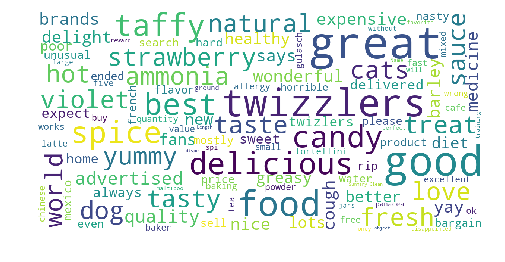

In [12]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(background_color='white', stopwords=stopwords,max_words=200,max_font_size=40,scale=3,
        random_state=1).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(messages["Summary_Clean"])

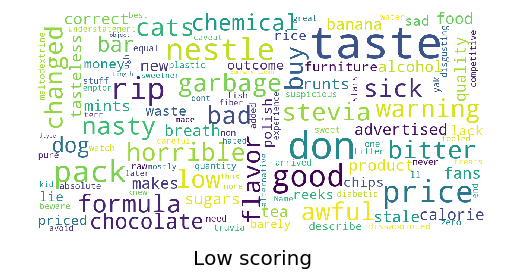

In [13]:
show_wordcloud(messages[messages.Score == 1]["Summary_Clean"], title = "Low scoring")

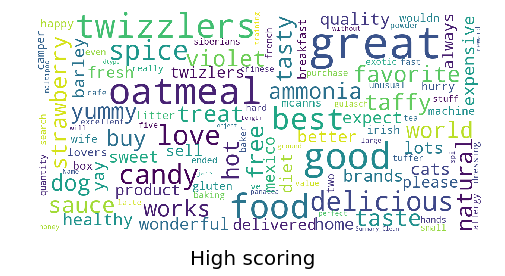

In [14]:
show_wordcloud(messages[messages.Score == 5]["Summary_Clean"], title = "High scoring")

# Applying Machine Learning algorithms

Now that we are done with prepocessing data, cleasing it and splitting the data into relevant testing and training dataset, we shall be applying multiple machine learning algorithms. 
The machine learning algorithms which we are applying are:
    -Multinomial Naive Bayes algorithm
    -Bernoulli Naive Bayes Algorithm
    -Logistic Regression
    
So, why these algorithms? 

Here, we basically want to perform Classification. Classification is the problem of identifying to which of a set of categories (sub-populations) a new observation belongs, on the basis of a training set of data containing observations (or instances) whose category membership is known.

Naive Bayes and Logistic Regression are highly regarded algorithms, which are useful for classification. The classigfication that we want to perform over here is basically to classify data based on sentiment as positive and negative.
Naive Bayes has a simple design, and it has often been demonstrated to be fast and intuitive when applying NLP.

Applying Multinomial Naive Bayes Algorithm. Fitting the X_train_tfidf, y_train into the model and performing prediction using X_test_tfidf.

In [39]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = model.predict(X_test_tfidf)

Applying Bernoulli Naive Bayes Algorithm. Fitting the X_train_tfidf, y_train into the model and performing prediction using X_test_tfidf.

In [40]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB().fit(X_train_tfidf, y_train)
prediction['Bernoulli'] = model.predict(X_test_tfidf)

Applying Logistic Regression. Fitting the X_train_tfidf, y_train into the model and performing prediction using X_test_tfidf.

In [41]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)
logreg_result = logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

Now, instead of running individual codes to check the accuracy of the model, we instead create a ROC Curve. The curve with the highest AUC value will show our "best" algorithm.
ROC stands for Receiver operating characteristic.
We use the matplotlib library to plot the ROC Curve.

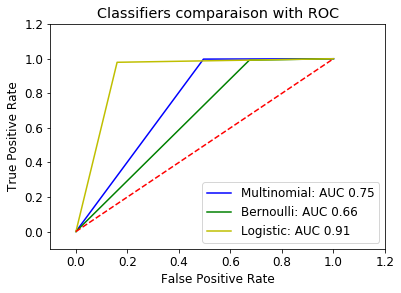

In [42]:
def formatt(x):
    if x == 'negative':
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



Here, we observe excellent performance by Logisitc Regression of 93% and a bit disappointing performance by the Naive Bayes Classifier.

Becuase of the high accuracy,we will move forward with Logistic Regression and thereby calculate a more detailed accuracy. We record acerage precision of 96% which is highly impressive.

In [43]:
print(metrics.classification_report(y_test, prediction['Logistic'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.88      0.84      0.86     16458
   negative       0.97      0.98      0.97     88705

avg / total       0.96      0.96      0.96    105163



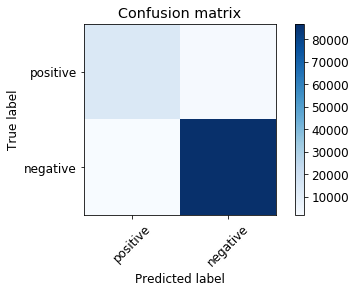

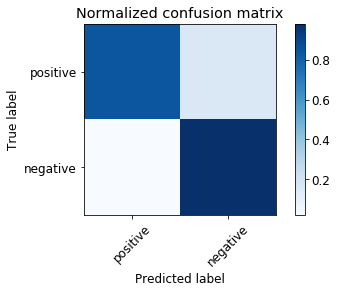

In [44]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=["positive", "negative"]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm = confusion_matrix(y_test, prediction['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)    

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
plt.show()

# Testing the data
Now, since we are done with the visualisation, we will look at what the best & words are by looking at the coefficients. 
We record pretty impressive results, with the word 'Worst' as the most negative coefficient and 'Best' as teh most positive coefficient. By looking at the other results as well, we can see that the results are pretty accurate and inline with the 96% average accuracy.

In [45]:
words = count_vect.get_feature_names()
feature_coefs = pd.DataFrame(
    data = list(zip(words, logreg_result.coef_[0])),
    columns = ['feature', 'coef'])

feature_coefs.sort_values(by='coef')

,feature,coef
966854,worst,-38.290870
983035,yuck,-29.647137
587825,not,-29.599232
820234,terrible,-28.370177
61499,awful,-28.095123
422148,horrible,-25.707169
569751,nasty,-23.288239
226986,disgusting,-22.939515
55461,at best,-22.936652
770983,stale,-22.344386


Now, we shall test the results on random strings. We will give an input in the form of  a string and and calculate the negative and postive probability of the sentence. 
"The whole experience was horrible. The smell was so bad that it literally made me sick." 
The sentence is clearly negative, and we expect a negative sentiment from the model as well. We record a solid 99% negative sentiment, owing to words like "horrible", "bad" and "sick". 

Clearly, the model works very well and the results are satisfactory.

In [46]:
def test_sample(model, sample):
    sample_counts = count_vect.transform([sample])
    sample_tfidf = tfidf_transformer.transform(sample_counts)
    result = model.predict(sample_tfidf)[0]
    prob = model.predict_proba(sample_tfidf)[0]
    print("Sample estimated as %s: negative prob %f, positive prob %f" % (result.upper(), prob[0], prob[1]))

test_sample(logreg, "The food was delicious, it smelled great and the taste was awesome")
test_sample(logreg, "The whole experience was horrible. The smell was so bad that it literally made me sick.")
test_sample(logreg, "The food was ok, I guess. The smell wasn't very good, but the taste was ok.")

Sample estimated as POSITIVE: negative prob 0.001410, positive prob 0.998590
Sample estimated as NEGATIVE: negative prob 0.999995, positive prob 0.000005
Sample estimated as NEGATIVE: negative prob 0.557754, positive prob 0.442246
